In [1]:
# import required libraries

# utilities
import numpy as np
import random
import pandas as pd

# stats
from scipy.stats import norm

# plotting
import matplotlib.pyplot as plt

# scikit - model development
# dataset splits
from sklearn.model_selection import train_test_split

# Classification models
from sklearn.ensemble import AdaBoostClassifier,VotingClassifier,BaggingClassifier,GradientBoostingClassifier,ExtraTreesClassifier,StackingClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.multioutput import  MultiOutputClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

#Clustering models
from sklearn.cluster import KMeans
from kneed import KneeLocator

#metrics
from sklearn.metrics import roc_curve,auc,accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import classification_report



In [2]:
# Initialize common variables
num_trials = 20
seed_value = 123467

data_file_path = "D:/PhD Program/Final Research/OLR/DS_1_Feature_w_MFCC_no_hilbert.csv"
data_file_path_ht = "D:/PhD Program/Final Research/OLR/DS_1_Feature_MFCC_hilbert_trans.csv"

# set random seed
random.seed(seed_value)
np.random.seed(seed_value)

In [3]:
# read the dataset

data_df_raw = pd.read_csv(data_file_path)
data_df_raw['new_sound_file_class'] = data_df_raw.apply(lambda x: 0 if x.sound_file_class==1 or x.sound_file_class==4 
                                                else (1 if x.sound_file_class==2 else 2), axis=1)
X_raw = data_df_raw[data_df_raw.columns[~data_df_raw.columns.isin(['sound_file_name', 'sound_file_class','new_sound_file_class','class_name','track id',' genre', 'genre_name'])]]
X_raw_orig = X_raw

data_df_ht = pd.read_csv(data_file_path_ht)
data_df_ht['new_sound_file_class'] = data_df_ht.apply(lambda x: 0 if x.sound_file_class==1 or x.sound_file_class==4 
                                                else (1 if x.sound_file_class==2 else 2), axis=1)
X_ht = data_df_ht[data_df_ht.columns[~data_df_ht.columns.isin(['sound_file_name', 'sound_file_class','new_sound_file_class','class_name','track id',' genre', 'genre_name'])]]
X_ht_orig = X_ht

# Factorize the target variable - emotion class/quadrant
y,unique_vals = pd.factorize(data_df_raw['sound_file_class'], sort=True)
#y_new,unique_vals = pd.factorize(data_df['new_sound_file_class'], sort=True)


D:\MyApps\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1870: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
D:\MyApps\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1870: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
D:\MyApps\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1870: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
D:\MyApps\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1870: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


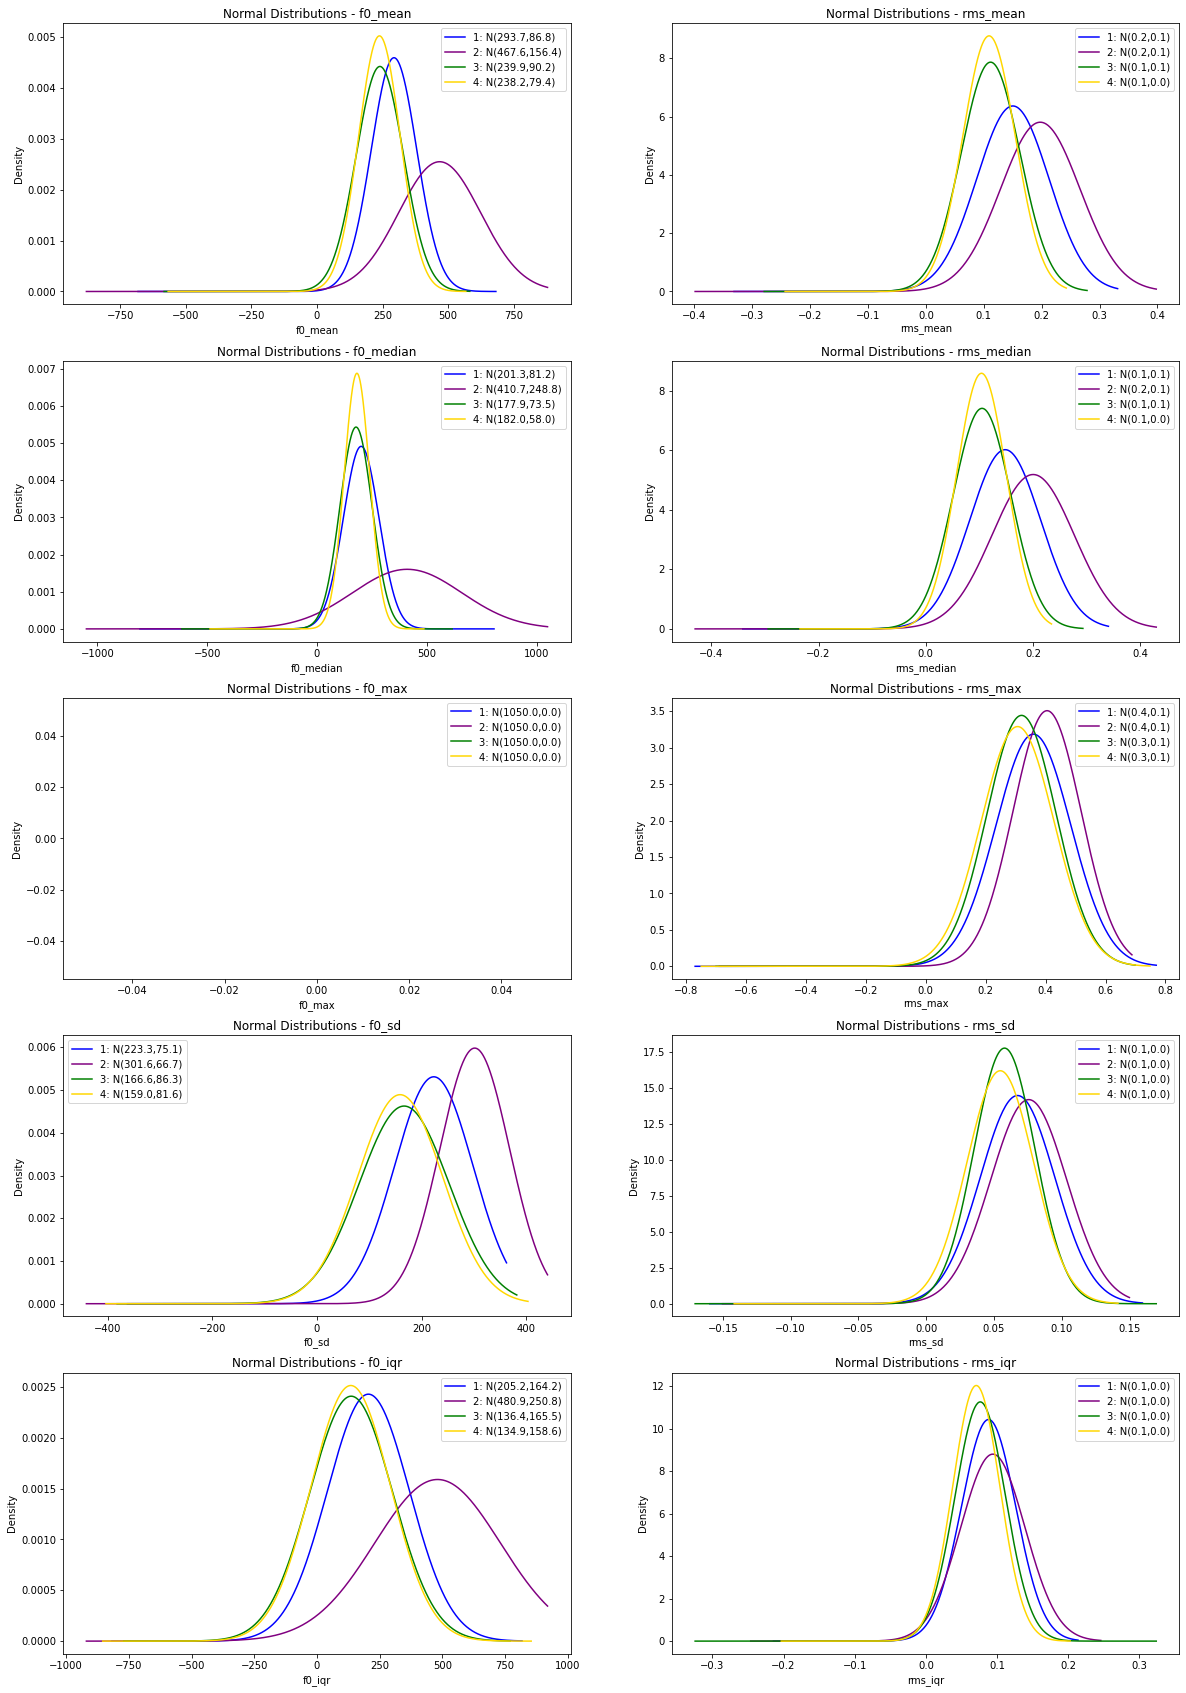

In [4]:
# plot normal distribution curve for core features: RMS, Power, Loudness and F0 

figure, axis = plt.subplots(5, 2, figsize= (20,30))

full_feat_cols = [['f0_mean', 'f0_median', 'f0_max', 'f0_sd', 'f0_iqr'],
                 ['rms_mean', 'rms_median', 'rms_max', 'rms_sd', 'rms_iqr']]

# class - validate class overlap
color_vals = ['blue','purple','green','gold']
#mean_cols = list(X_means.columns)
feat_col_cnt = 0
for feat_cols in full_feat_cols:
    #print(feat_cols)
    row_cnt = 0
    for col_val in feat_cols:
        cntr=0
        norm_df = data_df_raw[['sound_file_class',col_val]]

        for class_val in unique_vals:
            #print(class_val)
            class_df = norm_df[norm_df.sound_file_class==class_val]
            #print(class_df.head())
            mean_val = np.mean(class_df[col_val])
            sd_val = np.std(class_df[col_val])
            x = class_df[col_val]
            x_val = np.arange(max(x)*-1,max(x),0.001)
            label_val = str(class_val)+": N("+str(round(mean_val,1))+","+str(round(sd_val,1))+")"
            axis[row_cnt,feat_col_cnt].plot(x_val,norm.pdf(x_val,mean_val,sd_val),label = label_val, color=color_vals[cntr])    

            #plt.plot(x_val,norm.pdf(x_val,mean_val,sd_val),label = label_val, color=color_vals[cntr])    
            cntr +=1
        axis[row_cnt,feat_col_cnt].legend()
        axis[row_cnt,feat_col_cnt].set_ylabel("Density")
        axis[row_cnt,feat_col_cnt].set_xlabel(str(col_val))
        axis[row_cnt,feat_col_cnt].set_title("Normal Distributions - "+str(col_val))
        row_cnt +=1
    feat_col_cnt+=1
plt.show()

In [5]:
# # Extract only"_mean" columns for the time being
# X_means_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
# print(len(X_means_raw.columns))
# X_means_ht = X_ht_orig.loc[:,X_ht_orig.columns.str.contains("_mean")]
# print(len(X_means_ht.columns))

# #print(list(X_means.columns))
# # Split the data set into train & test
# # X_means = X_means[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
# #                    'spect_contrast_mean','zcr_mean', 'power_mean', 'mfcc_3_mean', 
# #                    'mfcc_8_mean', 'mfcc_12_mean','loudness_mean','chromagram_mean']]

# # X_means = X_means[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
# #                    'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean','chromagram_mean']]
# #X_means = X_means[['f0_mean','rms_mean','spect_centroid_mean','spect_rolloff_mean']]
# X = X_means_raw 
# X_ht = X_means_ht 
# # train test split
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y)
# X_train_ht, X_test_ht, y_train_ht, y_test_ht = train_test_split(X_ht,y,test_size=0.3,stratify=y)
# #X_train, X_test, y_train, y_test = train_test_split(X,y_new,test_size=0.3,stratify=y)
metrics_df = pd.DataFrame(columns=['dataset', 'model','num_classes','feature_set' ,'num_feat', 'acc_range', 'auc_range','f1s_range'])

In [6]:
# Ada boosting classifier
model_name = "Ada Boosting"
dataset_names = ['raw','ht']
feature_sets = ['All','Mean','Mean Subset']
for feat_set in feature_sets:
    X_raw = X_raw_orig
    X_ht = X_ht_orig
    if feat_set == 'Mean':
        X_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
        X_ht = X_ht_orig.loc[:,X_ht_orig.columns.str.contains("_mean")]
    elif feat_set == 'Mean Subset':
        X_means_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
        X_raw = X_means_raw[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
                               'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean','chromagram_mean']]        
        X_means_ht = X_ht_orig.loc[:,X_ht_orig.columns.str.contains("_mean")]
        X_ht = X_means_raw[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
                               'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean','chromagram_mean']]        

    for data_pos_val in range(len(dataset_names)):
        X = X_raw
        if dataset_names[data_pos_val]=='ht':
            X = X_ht
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y)
        num_feat = str(len(X_train.columns))
        #print(dataset_names[data_pos_val])
        avg_acc = []
        avg_auc = []
        avg_f1s = []
        for trial_num in range(30):
            ab_clf = AdaBoostClassifier(n_estimators=((trial_num+1)*20), random_state=0)
            ab_clf.fit(X_train,y_train)
            y_pred = ab_clf.predict(X_test)
            y_pred_prob = ab_clf.predict_proba(X_test)
            curr_acc = round(accuracy_score(y_test, y_pred),3)
            curr_auc = round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)
            curr_f1s = round(f1_score(y_test,y_pred,average="weighted"),3)
            avg_acc.append(curr_acc)
            avg_auc.append(curr_auc)
            avg_f1s.append(curr_f1s)

        #print(classification_report(y_test,y_pred))
        avg_acc_val = str(round(np.mean(avg_acc),3))
        acc_range = str(np.min(avg_acc))+" - "+(str(np.max(avg_acc)))

        avg_auc_val = str(round(np.mean(avg_auc),3))
        auc_range = str(np.min(avg_auc))+" - "+(str(np.max(avg_auc)))

        avg_f1s_val = str(round(np.mean(avg_f1s),3))
        f1s_range = str(np.min(avg_f1s))+" - "+(str(np.max(avg_f1s)))

        dict_tmp = {'dataset':dataset_names[data_pos_val],
                    'model':model_name,
                    'num_classes':len(unique_vals),
                    'feature_set':feat_set,
                    'num_feat':num_feat,
                    'acc_range':avg_acc_val+" ("+acc_range+")",
                    'auc_range':avg_auc_val+" ("+auc_range+")",
                    'f1s_range':avg_f1s_val+" ("+f1s_range+")"}
    #print(dict_tmp)
        metrics_df = metrics_df.append(dict_tmp, ignore_index=True)

metrics_df

,dataset,model,num_classes,feature_set,num_feat,acc_range,auc_range,f1s_range
0,raw,Ada Boosting,4,All,481,0.542 (0.515 - 0.581),0.769 (0.745 - 0.785),0.539 (0.515 - 0.583)
1,ht,Ada Boosting,4,All,481,0.528 (0.463 - 0.578),0.764 (0.721 - 0.779),0.524 (0.464 - 0.576)
2,raw,Ada Boosting,4,Mean,97,0.518 (0.485 - 0.57),0.762 (0.743 - 0.799),0.52 (0.489 - 0.571)
3,ht,Ada Boosting,4,Mean,97,0.531 (0.493 - 0.563),0.772 (0.724 - 0.798),0.528 (0.486 - 0.562)
4,raw,Ada Boosting,4,Mean Subset,9,0.513 (0.481 - 0.533),0.717 (0.7 - 0.768),0.512 (0.461 - 0.529)
5,ht,Ada Boosting,4,Mean Subset,9,0.535 (0.511 - 0.548),0.746 (0.739 - 0.768),0.523 (0.495 - 0.546)


In [7]:
# Random forest classifier

rf_clf = RandomForestClassifier(n_estimators=5000,
                                    max_depth=10,
                                    random_state=1,
                                    min_samples_split=0.02)
rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)
y_pred_prob = rf_clf.predict_proba(X_test)
curr_acc = accuracy_score(y_test, y_pred)

print(round(curr_acc,3))
print("AUC : "+ str(round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)))

print(classification_report(y_test,y_pred))

0.541
AUC : 0.814
              precision    recall  f1-score   support

           0       0.56      0.57      0.56        67
           1       0.77      0.78      0.77        68
           2       0.37      0.34      0.35        67
           3       0.46      0.47      0.46        68

    accuracy                           0.54       270
   macro avg       0.54      0.54      0.54       270
weighted avg       0.54      0.54      0.54       270



In [ ]:
# Gradient boosting classifier

gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train,y_train)
y_pred = gb_clf.predict(X_test)
y_pred_prob = gb_clf.predict_proba(X_test)
curr_acc = accuracy_score(y_test, y_pred)

print(round(curr_acc,3))
print("AUC : "+ str(round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)))

print(classification_report(y_test,y_pred))

In [ ]:
clf_ovr = OneVsRestClassifier(SVC())
class_model.fit(X_train,y_train)
y_pred = class_model.predict(X_test)
y_pred_prob = class_model.predict_proba(X_test)
curr_acc = accuracy_score(y_test, y_pred)

print(round(curr_acc,3))
print("AUC : "+ str(round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)))

print(classification_report(y_test,y_pred))

In [ ]:
clf_ovr = OneVsRestClassifier(SVC(kernel='poly', class_weight = 'balanced'))
class_model.fit(X_train,y_train)
y_pred = class_model.predict(X_test)
y_pred_prob = class_model.predict_proba(X_test)
curr_acc = accuracy_score(y_test, y_pred)

print(round(curr_acc,3))
print("AUC : "+ str(round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)))

print(classification_report(y_test,y_pred))

In [ ]:
clf_ovr = OneVsRestClassifier(SVC(kernel='linear'))
class_model.fit(X_train,y_train)
y_pred = class_model.predict(X_test)
y_pred_prob = class_model.predict_proba(X_test)
curr_acc = accuracy_score(y_test, y_pred)

print(round(curr_acc,3))
print("AUC : "+ str(round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)))

print(classification_report(y_test,y_pred))

In [ ]:
clf_ovr = OneVsRestClassifier(SVC(kernel='sigmoid'))
class_model.fit(X_train,y_train)
y_pred = class_model.predict(X_test)
y_pred_prob = class_model.predict_proba(X_test)
curr_acc = accuracy_score(y_test, y_pred)

print(round(curr_acc,3))
print("AUC : "+ str(round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)))

print(classification_report(y_test,y_pred))

In [ ]:
# Hard Voting Classifier RandomForestClassifier, GradientBoostingClassifier and SVC
rf_clf = RandomForestClassifier(n_estimators=5000,
                                    max_depth=10,
                                    random_state=1,
                                    min_samples_split=0.02)
gb_clf = GradientBoostingClassifier()
svc_clf = SVC()
ab_clf = AdaBoostClassifier(n_estimators=200, random_state=0)
class_model = VotingClassifier(estimators=[('rf', rf_clf), ('gb', gb_clf), ('svc', svc_clf),('ab',ab_clf)], voting='hard')
# class_model = StackingClassifier(estimators=[('rf', rf_clf), ('gb', gb_clf), ('gau', knn_clf)],
#                                  final_estimator=RandomForestClassifier())

#class_model = gau_clf
class_model.fit(X_train,y_train)
y_pred = class_model.predict(X_test)
y_pred_prob = class_model.predict_proba(X_test)
curr_acc = accuracy_score(y_test, y_pred)

print(round(curr_acc,3))
print("AUC : "+ str(round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)))

print(classification_report(y_test,y_pred))

In [ ]:
# Stacking Classifier RandomForestClassifier, GradientBoostingClassifier and SVC
class_model = StackingClassifier(estimators=[('rf', rf_clf), ('gb', gb_clf), ('svc', svc_clf),('ab',ab_clf)],
                                 final_estimator=RandomForestClassifier())

class_model.fit(X_train,y_train)
y_pred = class_model.predict(X_test)
y_pred_prob = class_model.predict_proba(X_test)
curr_acc = accuracy_score(y_test, y_pred)

print(round(curr_acc,3))
print("AUC : "+ str(round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)))

print(classification_report(y_test,y_pred))

In [4]:
# Kmeans cluster to validate classes

cluster_df = X_raw
cluster_df.head()

,f0_mean,f0_median,f0_max,f0_sd,f0_iqr,rms_mean,rms_median,rms_max,rms_sd,rms_iqr,...,mel_63_median,mel_63_max,mel_63_sd,mel_63_iqr,loudness_mean,chromagram_mean,chromagram_median,chromagram_max,chromagram_sd,chromagram_iqr
0,221.3273,140.0118,1050,210.4100,74.2560,0.2020,0.2111,0.4263,0.0790,0.0829,...,0.0732,55.6024,2.3038,0.1938,-12.5454,0.5204,0.4881,1,0.2843,0.4679
1,262.7001,168.1718,1050,237.4281,97.2186,0.1292,0.1271,0.3141,0.0471,0.0599,...,0.4355,23.5708,1.8410,1.0867,-14.9155,0.4321,0.3690,1,0.2899,0.4328
2,358.0880,158.1871,1050,318.0516,439.5384,0.2693,0.2911,0.4749,0.0972,0.1086,...,0.5687,47.7192,3.5812,1.8608,-10.5852,0.4890,0.4352,1,0.2882,0.4701
3,262.5545,246.9974,1050,132.6478,145.6380,0.1728,0.1718,0.3207,0.0398,0.0451,...,0.0439,2.0740,0.1527,0.0974,-14.5174,0.3573,0.2762,1,0.2830,0.3542
4,226.5964,187.0110,1050,153.3794,87.0989,0.0894,0.0919,0.2704,0.0426,0.0561,...,0.0307,23.2292,1.8784,0.1396,-18.8632,0.4043,0.3343,1,0.2848,0.3899


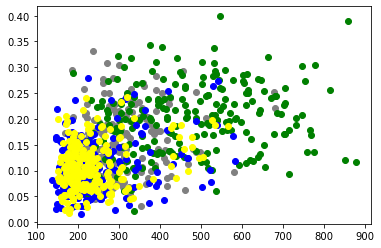

In [33]:
X = data_df_raw[['f0_mean','rms_mean','sound_file_class']]
X_class = X[X.sound_file_class==1]
x = X_class.f0_mean
y = X_class.rms_mean
plt.scatter(x,y,color="gray")
X_class = X[X.sound_file_class==2]
x = X_class.f0_mean
y = X_class.rms_mean
plt.scatter(x,y,color="green")
X_class = X[X.sound_file_class==3]
x = X_class.f0_mean
y = X_class.rms_mean
plt.scatter(x,y,color="blue")
X_class = X[X.sound_file_class==4]
x = X_class.f0_mean
y = X_class.rms_mean
plt.scatter(x,y,color="yellow")

plt.plot()
plt.show()

In [40]:
sse_cluster = []
for k in range(1,11,1):
    k_means_model = KMeans(n_clusters = k).fit(X)
    sse_cluster.append(k_means_model.inertia_)

D:\MyApps\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


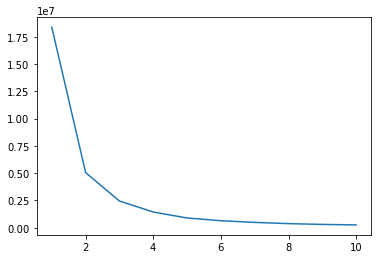

In [41]:
plt.plot(range(1,11,1),sse_cluster)

In [31]:
l1 = KneeLocator(range(1,11), sse_cluster, curve='convex',direction = 'decreasing')
l1.elbow

KMeans(n_clusters=3)
